# R-HyDAMO

This model generator developed by HKV makes it possible to create a Ribasim model from D-Hydro output files. For more information about Ribasim, please take a look at https://deltares.github.io/Ribasim/ which is constructed by Deltares.

Note that this is a notebook still under construction. This is a temporary version. If there are any questions or comments, please let us know via the GitHub environment.

# Update version

# Import relevant libraries, functions and data

In [1]:
#import relevant libraries
# import ribasim #remove last four string values: C:\Users\Bruijns\Anaconda3\envs\TKI_Ribasim\Lib\site-packages\ribasim_pip
import ribasim
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import geopandas as gpd
import xarray as xr
import ugrid as ug
from ugrid import UGrid, UGridNetwork1D
import xugrid as xu
from mpl_toolkits.mplot3d import Axes3D
from shapely.geometry import Point, LineString
import timeit
import os
import sys
import warnings


In [2]:
#import custom functions
from Functions.custom_functions import *

The output folder of D-Hydro should contain a _map.nc file. This netCDF file will be the main source of data to construct the Ribasim model. 

In [39]:
#select the location of the nc_map file of D-HYDRO, and give the upcoming Ribasim model a name
nc_path =  r"Data\DFM_map.nc"
model_name = 'HogeRaamStationair_Q_0_01'

In [40]:
#Define whether dummy values should be used. For now, only the TabulatedRC can be False
dummy_TabulatedRC = False
dummy_profiles = True
dummy_initial_storage = True
dummy_forcing = True

#shorten = False


In [41]:
#define the dummy values
if dummy_profiles == True:
    level_low_dummy, level_high_dummy = 0, 30 #m
    area_low_dummy, area_high_dummy = 0, 10 #m2
    storage_dummy = 1000 #m3
    discharge_low_dummy, discharge_high_dummy = 0.0, 3.5 #m3/s

First, load in this netCDF file and check whether the network including the waterlevel looks like expected.

In [42]:
#some variables loaded in through xarray are not compatible with xugrid. Use xr for now, change later.
map_file = xr.open_dataset(nc_path)

edge_nodes = map_file['mesh1d_edge_nodes']
x_coordinates_nodes = map_file['mesh1d_node_x']
y_coordinates_nodes = map_file['mesh1d_node_y']
del(map_file)

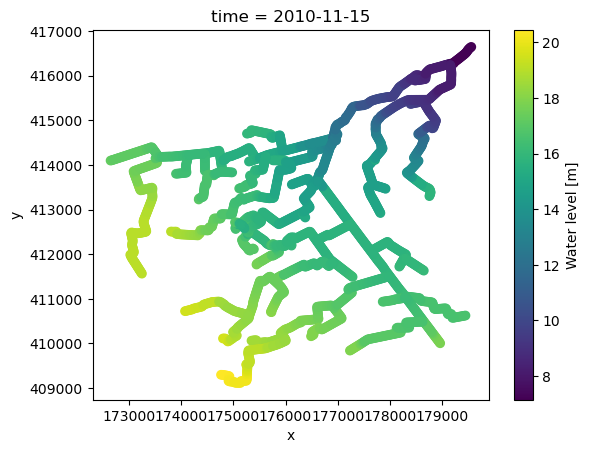

In [7]:
map_file = xu.open_dataset(nc_path)
map_file["mesh1d_s1"][-1].ugrid.plot(cmap="viridis") #plot the last timestep of the D-Hydro simulation to get an impression of the model output

In [8]:
map_file['mesh1d_edge_nodes'] = edge_nodes #to be updated, see box above

# Q(h)-relations

One of the main nodes are the TabulatedRatingCurves. These are in essence Q(h) relations. First do some visual inspections before adding this straight to the data.

Coordinates of the nodes and edges are likely to be correct


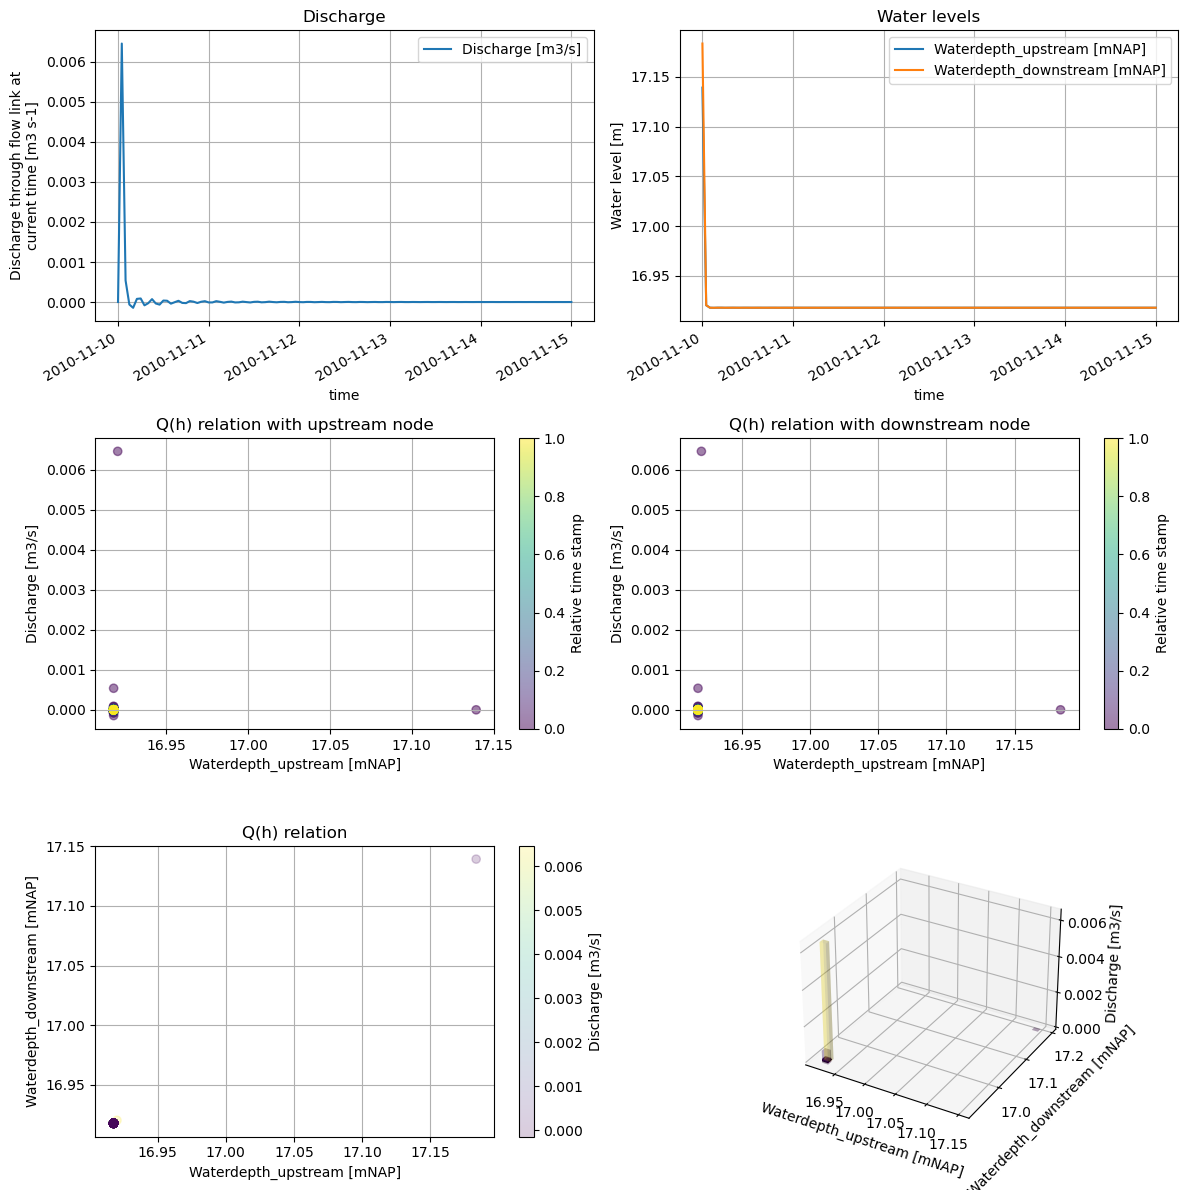

In [9]:
plot_Q_h(Q = map_file['mesh1d_q1'], #discharge
         h = map_file['mesh1d_s1'], #waterlevel
         edges = map_file['mesh1d_edge_nodes'], #connection network between the discharge and waterlevels
         edge_n = 3, #sample
         threeD = True) #whether to plot a 3D figure

# Attribute converter

## TRC, Basins, edges

First the coordinates of each node has to be converted to a basin node in Ribasim. The locations can be retrieved from the map_file.

In [10]:
TRC, basins, edges = attribute_converter(x_coordinates_nodes = map_file['mesh1d_node_x'], 
                                         y_coordinates_nodes = map_file['mesh1d_node_y'], 
                                         edges = map_file['mesh1d_edge_nodes'])
    

# Boundaries

The boundary nodes will first be identified from the map_file. However, they are already present in the regular nodes. Later in the script these nodes will be filtered out of the basin nodes. 

In [11]:
BoundaryNode, Terminal = BoundaryNode_Terminal(x_coordinates_nodes = x_coordinates_nodes,
                                               y_coordinates_nodes = y_coordinates_nodes,
                                               edges = edge_nodes)


# Filling Q(h) tables

In the beginning of the code we have seen some examples of the Q(h) relationships. Now these should be embedded in tabulated form. Depending on the size of the model, this can take up to several minutes.

In [12]:
TRC_table = fill_Q_h(Q = map_file['mesh1d_q1'], 
                     h = map_file['mesh1d_s1'], 
                     edges = map_file['mesh1d_edge_nodes'], 
                     TRC = TRC, 
                     upstream = True)

Execution time filling the entire TRC: 19.7658312 seconds


# Filter attributes and tables

Filter the LevelControl and Terminal from the basin table. For now, leave the type_node as 'Basin' since the generator currently works for simplified drainage calculations, where no BoundaryNodes are required.

In [13]:
# Filter first the Upstream Boundary nodes out of the basins
filtered_basins = filter_basins_LevelControl(basins = basins, 
                                             LevelControl = BoundaryNode, #to update: change name "LevelControl". Here below as well
                                             type_node = 'Basin') #for the drainage calculation, call it "basin" 
                                             # type_node = 'FlowBoundary')

# Filter secondly the Terminal(s) out of the basins
filtered_basins = filter_basins_LevelControl(basins = filtered_basins,
                                             LevelControl = Terminal,
                                             type_node = 'Basin') #for the drainage calculation, call it "basin" 
                                             # type_node = 'Terminal') #for the drainage calculation, call it "basin" 


# Last alterations of the DataFrames

In [14]:
final_nodes = add_TRC_to_nodes(basins=filtered_basins,
                               TRC = TRC)

## Update edges

The initial created edges go currently from basin to basin. However, the TabulatedRatingCurves have been added, so the edges should pass these attributes as well.

In [15]:
updated_edges = updating_edges(edges = edges,
                               TRC = TRC)


In [16]:
updated_edges = filter_updated_edges(updated_edges = updated_edges, 
                                     final_nodes = final_nodes)

# Embed Terminal

In [17]:
final_nodes, terminal_node = embed_terminal(Terminal = Terminal, 
                                            final_nodes = final_nodes)

# Python Ribasim

## Set up the nodes

In [18]:
node = ribasim.Node(static = gpd.GeoDataFrame(
                    data = final_nodes['type'],
                    index = final_nodes.node_id,
                    geometry = final_nodes.geometry,
                    crs = 'EPSG:28992')
                    )

## Set up the edges


In [19]:
lines = ribasim.utils.geometry_from_connectivity(node, 
                                                 from_id = updated_edges.from_node_id_new, 
                                                 to_id = updated_edges.to_node_id_new)

edge = ribasim.Edge(
    static=gpd.GeoDataFrame(
        data={
            "from_node_id": updated_edges.from_node_id_new,
            "to_node_id": updated_edges.to_node_id_new,
            "edge_type": len(updated_edges.from_node_id_new) * ["flow"],
        },
        geometry=lines,
        crs="EPSG:28992",
    )
)

## Set up the Terminal

In [20]:
terminal = ribasim.Terminal(
    static=pd.DataFrame(
        data={
            "node_id": [terminal_node],
        }
    )
)

## Overwrite the Tabulated Rating Curve

In [21]:
if dummy_TabulatedRC == True:
    dummy_TRC = create_dummy_TRC(n_Qh_relations = 7, 
                                 step_size = 5,
                                 TRC_table = TRC_table)
    
    TRC_table = dummy_TRC #overwrite the actual TRC with the dummy version
    filtered_df = dummy_TRC

## Set up the profiles

In [22]:
basins = final_nodes.loc[final_nodes['type'] == 'Basin']
node_id_basins = basins.index.values

In [23]:
if dummy_profiles == True:
    
    profiles = create_dummy_profiles(node_id_basins = node_id_basins, 
                                          area_low_dummy = area_low_dummy, 
                                          area_high_dummy = area_high_dummy, 
                                          level_low_dummy = level_low_dummy, 
                                          level_high_dummy = level_high_dummy)

## Set up the initial condition

In [24]:
if dummy_initial_storage == True:
    IC = create_dummy_initial_storage(node_id_basins = node_id_basins,
                                      storage_dummy = storage_dummy)

## Set up the basins including forcing

In [25]:
if dummy_forcing == True:
    static = create_dummy_forcing(node_id_basins = node_id_basins)

In [26]:
basin = ribasim.Basin(profile=profiles, 
                      static=static,
                      forcing = None,
                      state = IC)

## Set up the rating curves: (under construction)

The TRC_table is really large since we took a Q and h sample for every timestep for each node. This method will be adjusted later, so take for now every 10th row to reduce computational costs. Also remove the duplicates and where the discharge is negative.

This will be updated later, when a series of stationary D-HYDRO simulations are available.

### First Control

In [27]:
if dummy_TabulatedRC != True:
    filtered_df = TRC_table[TRC_table.index % 10 == 0].copy()    # Keep every 10th row to reduce size
    filtered_df = filtered_df.drop_duplicates() #remove duplicate rows
    filtered_df.reset_index(drop=True, inplace=True) # Reset the index of the filtered DataFrame

    #remove all rows where the Q is negative or zero
    # filtered_df.discharge = abs(filtered_df.discharge) #dont change the direction of the flow!
    filtered_df = filtered_df[filtered_df.discharge > 0.01]
    filtered_df = filtered_df.round({'level': 2, 'discharge':4}) #round to two decimals of the levels, to avoid having number which are almost duplicates
    

In [28]:
if dummy_TabulatedRC != True:
    integer_list = list(range(TRC_table.node_id.min(), TRC_table.node_id.max() + 1))


In [29]:
if dummy_TabulatedRC != True:
    # Sort by node_id, level, and discharge
    sorted_df = filtered_df.sort_values(['node_id', 'level', 'discharge'])

    # Apply the function within each node_id group
    sorted_df = sorted_df.groupby('node_id', group_keys=False).apply(drop_descending_discharge)

    # Reset the index of the DataFrame
    filtered_df = sorted_df.reset_index(drop=True)

### Second control

In [30]:
if dummy_TabulatedRC != True:
    too_few_datapoints = find_infrequent_nodes(filtered_df, 'node_id', 2)
    # too_few_datapoints

In [ ]:
if dummy_TabulatedRC != True:
    # Step 1: Generate a list of all integers between 2590 and 5177. update: dont hard code this

    # Step 2: Convert the node_id column to a set
    node_id_set = set(filtered_df['node_id'])

    # Step 3: Check if each integer exists in the node_id set
    missing_integers = []
    for integer in integer_list:
        if integer not in node_id_set:
            missing_integers.append(integer)

    missing_integers = missing_integers + too_few_datapoints
    # print("Missing integers:", missing_integers)

In [33]:
if dummy_TabulatedRC != True:
    # give some dummy values to the nodes where a negative discharge was present
    filtered_df.columns
    temp_RC = pd.DataFrame(columns = filtered_df.columns)
    temp_RC.node_id = missing_integers
    temp_RC.level = level_low_dummy
    temp_RC.discharge = discharge_low_dummy

    temp_RC2 = pd.DataFrame(columns = filtered_df.columns)
    temp_RC2.node_id = missing_integers
    temp_RC2.level = level_high_dummy
    temp_RC2.discharge = discharge_high_dummy

    filtered_df = pd.concat([filtered_df, temp_RC, temp_RC2])

    filtered_df = filtered_df.sort_values(by = ['node_id', 'level', 'discharge'])

    # if shorten == True:
    #     filtered_df.node_id -= filtered_df.node_id.min()-25 #hard coded, adjust later


### Third Control
Sort by node_id, h and Q. Remove the row if the Q is smaller than previous.   
Next, remove all h for which Q = 0. Give a dummy value where if h = 0, Q = 0

In [34]:
if dummy_TabulatedRC != True:
    # Create a DataFrame with the new row
    new_rows_low = pd.DataFrame({'node_id': sorted_df['node_id'].unique(), 'level': level_low_dummy, 'discharge': discharge_low_dummy})
    new_rows_high = pd.DataFrame({'node_id': sorted_df['node_id'].unique(), 'level': level_high_dummy, 'discharge': discharge_high_dummy})

    # Concatenate the new rows with the sorted_df DataFrame
    sorted_df = pd.concat([filtered_df, new_rows_low, new_rows_high], ignore_index=True)

    # Sort the DataFrame by node_id, level, and discharge again
    sorted_df = sorted_df.sort_values(['node_id', 'level', 'discharge'])
    filtered_df = sorted_df

In [35]:
#remove duplicate h's within deach node_id
print('Number of Qh relations before removing duplicate h-values =', len(filtered_df))
duplicates = filtered_df.duplicated(subset=['node_id', 'level'])
# Get the rows with duplicate levels within the same node_id
duplicate_rows = filtered_df[duplicates]
filtered_df.drop_duplicates(subset=['node_id', 'level'], inplace=True)
print('Number of Qh relations after removing duplicate h-values =', len(filtered_df))

#remove duplicate Q's within deach node_id
print('Number of Qh relations before removing duplicate Q-values =', len(filtered_df))
duplicates = filtered_df.duplicated(subset=['node_id', 'discharge'])
# Get the rows with duplicate levels within the same node_id
duplicate_rows = filtered_df[duplicates]
filtered_df.drop_duplicates(subset=['node_id', 'discharge'], inplace=True)
print('Number of Qh relations after removing duplicate Q-values =', len(filtered_df))


Number of Qh relations before removing duplicate h-values = 13782
Number of Qh relations after removing duplicate h-values = 6811
Number of Qh relations before removing duplicate Q-values = 6811
Number of Qh relations after removing duplicate Q-values = 6810


### Create the rating_curve

In [36]:
rating_curve = ribasim.TabulatedRatingCurve(
    static=pd.DataFrame(
        data={
            "node_id": filtered_df.node_id,
            "level": filtered_df.level,
            "discharge": filtered_df.discharge,
        }
    )
)

## Store output

In [37]:
#Setup a model
model = ribasim.Model(
    modelname=model_name,
    node=node,
    edge=edge,
    basin=basin,
    # level_boundary=level_boundary,
    # flow_boundary=flow_boundary,
    # pump=pump,
    # linear_resistance=linear_resistance,
    # manning_resistance=manning_resistance,
    tabulated_rating_curve=rating_curve,
    # fractional_flow=fractional_flow,
    terminal=terminal,
    starttime="2020-01-01 00:00:00",
    endtime="2020-01-10 00:00:00",
)

In [38]:
if not os.path.exists('Results\Models'):
   os.makedirs('Results\Models')

path = r'Results\Models'
path = os.path.join(path, '', model_name)
model.write(path)

The model is done now. You can open the created gpkg file in QGIS, by making use of the Ribasim plugin of Deltares. 

In [ ]:
# model.plot()

The TRC_table contains rows with NaN where a terminal is present (if the default option of upstream == True is still present, other wise the filtering has to be done based on the upstream boundaries) 
